# Udacity Machine Learning Capstone Project
## Name: Robert Martinez
## Title: Predicting Kickstarter Project Success (and Success Factors) 

# Part 1: Import Data and Tools

In [2]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,f1_score,make_scorer

pd.options.display.float_format = "{:.2f}".format
sns.set(font_scale=2)
plt.style.use('fivethirtyeight')

In [3]:
# Import the data

data = pd.read_csv("ks-projects-201801.csv")

# Set random seed for reproducibility
np.random.seed(42)

print("The dataset has {} observations on {} features.".format(data.shape[0],data.shape[1]))

The dataset has 378661 observations on 15 features.


In [4]:
data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [6]:
data.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,378661.00,378661.00,378661.00,378661.00,374864.00,378661.00,378661.00
mean,1074731191.99,49080.79,9682.98,105.62,7036.73,9058.92,45454.40
std,619086204.32,1183391.26,95636.01,907.19,78639.75,90973.34,1152950.06
min,5971.00,0.01,0.00,0.00,0.00,0.00,0.01
25%,538263516.00,2000.00,30.00,2.00,16.98,31.00,2000.00
50%,1075275634.00,5200.00,620.00,12.00,394.72,624.33,5500.00
75%,1610148624.00,16000.00,4076.00,56.00,3034.09,4050.00,15500.00
max,2147476221.00,100000000.00,20338986.27,219382.00,20338986.27,20338986.27,166361390.71


In [7]:
data.isna().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [8]:
data[(data.country == 'N,0"') & (data['usd pledged'].isna())].count()

ID                  3797
name                3797
category            3797
main_category       3797
currency            3797
deadline            3797
goal                3797
launched            3797
pledged             3797
state               3797
backers             3797
country             3797
usd pledged            0
usd_pledged_real    3797
usd_goal_real       3797
dtype: int64

# Part 2: Data Exploration and Pre-Processing

## Exploring the Features

Exploring the number of unique observations per feature is important, as many of the features are categorical, e.g 'main_category'. To be used in a machine learning model, the observations for such features must be converted to numerical values, either through label encoding (converting the string values of the observations to corresponding numerical values) or one-hot encoding (creating a binary categorical feature for each category observed for the original feature).

Before performing data cleaning steps, however, we explore the data visually with a few plots.

### Findings

* *main_category* is a candidate for one-hot-encoding. There are 15 distinct main categories.
* *currency* is also a candidate for one-hot encoding, with 14 distinct values.
* *country* can be one-hot encoded, with 23 distinct values.
* *category* has too many distinct values (159), and I think enough of the information about it is captured in the *main_category* feature, therefore I will drop it from the dataset.
* The target value, *states*, has 6 distinct values. I intend to reduce these to two categories, namely 'successful' (encoded as 1) and 'unsuccessful' (encoded as 0). To do so I will leave the 'successful' category unchanged, and will subsume the values 'failed', 'canceled' and 'suspended' into the 'unsuccessful' category. Rows with the state 'live' will be excluded from this exercise since a final determination cannot be made on their success value as yet.
* Rows with state 'undefined' will be explored and adjusted based on whether or not pledges exceed goal values (and will be assigned '1' if so, and 0 if not). We will work on the assumption that the state was assigned 'undefined' due to an error in data capture, but that we can reassign it to desired state categories based on the target conditions.

    * **NB**: The 'live' projects can perhaps be used as an extra test set for the final model, and in a further exercise model predictions using the data for these projects can be compared to their real world outputs.

In [9]:
# Number of unique values for each column
uniques = pd.DataFrame(data.nunique(),columns=['Unique Observations'])
uniques

,Unique Observations
ID,378661
name,375764
category,159
main_category,15
currency,14
deadline,3164
goal,8353
launched,378089
pledged,62130
state,6


In [10]:
maincats = data.main_category.unique()
statenames = data.state.unique()
countries = data.country.unique()

print ("The {} main categories of projects in this dataset are: \n{}".format(data.main_category.nunique(),', '.join(maincats)))
print ("\nProjects in this dataset exist in the following {} states: \n * {}".format(data.state.nunique(), '\n * '.join(statenames)))
print ("\nThe projects originated from the following {} countries: {} ".format(data.country.nunique(), ', '.join(countries)))

The 15 main categories of projects in this dataset are: 
Publishing, Film & Video, Music, Food, Design, Crafts, Games, Comics, Fashion, Theater, Art, Photography, Technology, Dance, Journalism

Projects in this dataset exist in the following 6 states: 
 * failed
 * canceled
 * successful
 * live
 * undefined
 * suspended

The projects originated from the following 23 countries: GB, US, CA, AU, NO, IT, DE, IE, MX, ES, N,0", SE, FR, NL, NZ, CH, AT, DK, BE, HK, LU, SG, JP 


In [11]:
states = pd.DataFrame(data.state.value_counts())
states

,state
failed,197719
successful,133956
canceled,38779
undefined,3562
live,2799
suspended,1846


## Missing and Unusual Values

### Findings
* Found 4 projects with missing values for the 'name' variable, which can be ignored for now.
* Found 3797 projects with missing values for the 'usd pledged' variable, which needs to be dealt with.
* One option to treat with the missing values in 'usd pledged' would be to fill them in using the *fillna()* function. However, the column *'usd pledged'* overlaps significantly with *usd_pledged_real* and little harm is done by removing this column entirely.
* Found some unusual values for *country*, *state* and *'usd pledged'* and checked to see if they all line up with each other, ie. projects with country 'N,0' line up with NaN for *usd pledged* and *state* 'undefined'. Most of the rows featuring each of these three conditions featured all of them.

* While exploring the projects with unusual values, I found that there are a number of projects (~3000) with non-zero amounts of money pledged, but zero backers. Not sure how to treat with this. This will also impact on a feature I want to create, "Average Contribution per Backer", since we'll have division by zero problems for these projects with this attribute.

In [12]:
# Show columns by the amount of missing values
data.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [13]:
data.loc[(data.backers == 0) & (data.pledged > 0) & (data.country != 'N,0"')]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
69554,1354010125,The Falcon Fly By,Film & Video,Film & Video,USD,2016-06-04,5000.00,2016-04-05 15:08:31,1.00,failed,0,US,0.00,1.00,5000.00
205098,2044861703,iStandUp!,Product Design,Design,USD,2014-12-31,50000.00,2014-11-19 19:20:02,218.00,failed,0,US,218.00,218.00,50000.00
369139,950767056,Sins Of A Son,Documentary,Film & Video,USD,2010-09-04,3500.00,2010-07-02 23:41:15,1.00,failed,0,US,1.00,1.00,3500.00


In [14]:
# Number of projects with state undefined
undefstate = data[data.state == 'undefined'].count()["ID"]
print ("Number of projects with state 'undefined' = {}".format(undefstate))

# Number of projects with USD Pledged as NaN
nullpledge = data[data['usd pledged'].isnull()].count()["ID"]
print ("Number of projects with 'usd pledged' as NaN = {}".format(nullpledge))

# Number of projects with Country as 'N,0"'
N0 = data[data.country == 'N,0"'].count()["ID"]
print ("Number of projects with country as 'N,0\"' = {}".format(N0))

# Number of projects with all weird values
allprobs = data[(data.state == 'undefined') & (data['usd pledged'].isnull()) & (data.country == 'N,0"')].count()["ID"]
print ("Number of projects with all three unusual conditions = {}".format(allprobs))

Number of projects with state 'undefined' = 3562
Number of projects with 'usd pledged' as NaN = 3797
Number of projects with country as 'N,0"' = 3797
Number of projects with all three unusual conditions = 3562


In [15]:
data.loc[(data.state == 'undefined') & (data['usd pledged'].isnull()) & (data.country == 'N,0"')]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
169,1000694855,STREETFIGHTERZ WHEELIE MURICA,Film & Video,Film & Video,USD,2014-09-20,6500.00,2014-08-06 21:28:36,555.00,undefined,0,"N,0""",nan,555.00,6500.00
328,100149523,Duncan Woods - Chameleon EP,Music,Music,AUD,2015-08-25,4500.00,2015-08-04 12:05:17,4767.00,undefined,0,"N,0""",nan,3402.08,3211.53
632,1003023003,The Making of Ashley Kelley's Debut Album,Music,Music,USD,2015-04-09,3500.00,2015-03-10 20:06:13,3576.00,undefined,0,"N,0""",nan,3576.00,3500.00
647,1003130892,Butter Side Down Debut Album,Music,Music,USD,2015-11-26,6000.00,2015-11-02 22:09:19,7007.80,undefined,0,"N,0""",nan,7007.80,6000.00
749,1003629045,Chase Goehring debut EP,Music,Music,USD,2016-03-21,3000.00,2016-02-23 03:09:49,3660.38,undefined,0,"N,0""",nan,3660.38,3000.00
824,1004013077,Spencer Capier Instrumental Project 2015,Music,Music,CAD,2014-10-10,4000.00,2014-09-10 22:51:01,4760.00,undefined,0,"N,0""",nan,4251.14,3572.39
844,1004126342,LUKAS LIGETI'S 50TH BIRTHDAY FESTIVAL: ORIGINA...,Music,Music,USD,2015-06-11,5000.00,2015-05-15 02:12:35,6370.00,undefined,0,"N,0""",nan,6370.00,5000.00
864,1004255433,The Battle For Breukelen: A Neighborhood Epic,Film & Video,Film & Video,USD,2015-11-07,6000.00,2015-10-10 18:45:24,6695.00,undefined,0,"N,0""",nan,6695.00,6000.00
870,1004298993,"""Tamboura Plays Violin"" - a collection of Pop ...",Music,Music,USD,2015-03-28,2750.00,2015-02-11 19:28:27,2926.00,undefined,0,"N,0""",nan,2926.00,2750.00
890,1004402863,Nightingale Noel - An A Cappella Holiday CD,Music,Music,USD,2015-12-11,1200.00,2015-11-11 21:02:55,1585.00,undefined,0,"N,0""",nan,1585.00,1200.00


In [16]:
# Number of projects with 0 backers but non-zero amounts pledged
phantom_backers = data[(data.backers == 0) & (data.pledged > 0)].count()["ID"]

print("Number of projects with phantom backers = {}".format(phantom_backers))

Number of projects with phantom backers = 3082


## Data Visualisation

1. Categories Bar Chart - **Done**
2. States Bar Chart - **Done**
3. Distribution of Goals
4. Distribution of Pledges

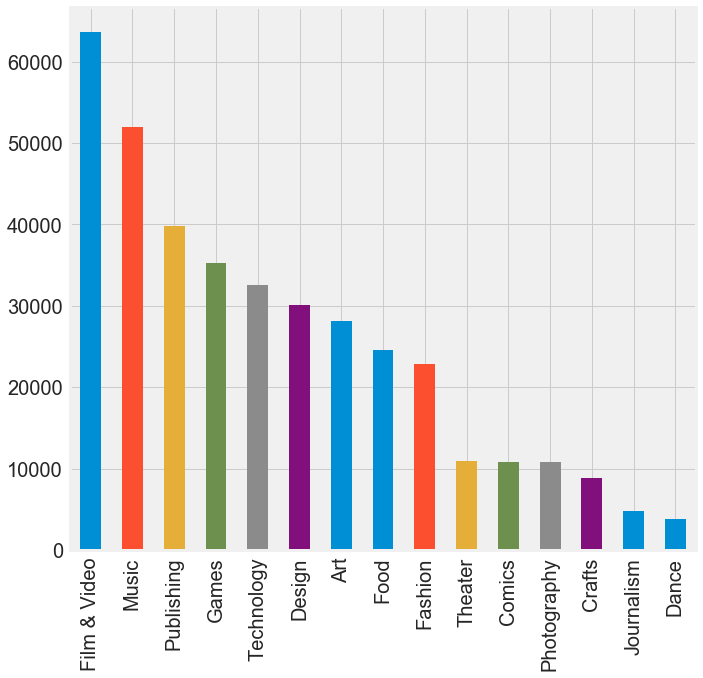

In [17]:
# Bar Chart of Main Categories
data['main_category'].value_counts().plot(kind='bar',figsize=(10,10))

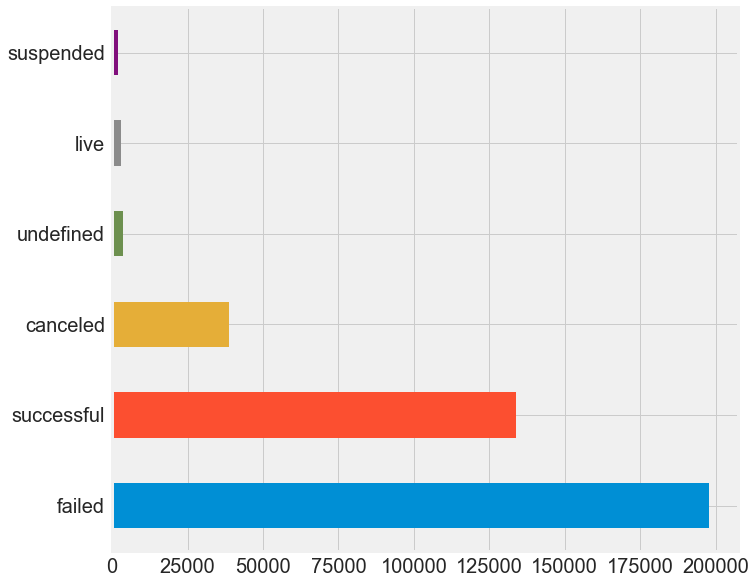

In [18]:
# Bar Chart of States
data['state'].value_counts().plot(kind='barh',figsize=(10,10))

Text(0.5,20.8469,'Main Category')

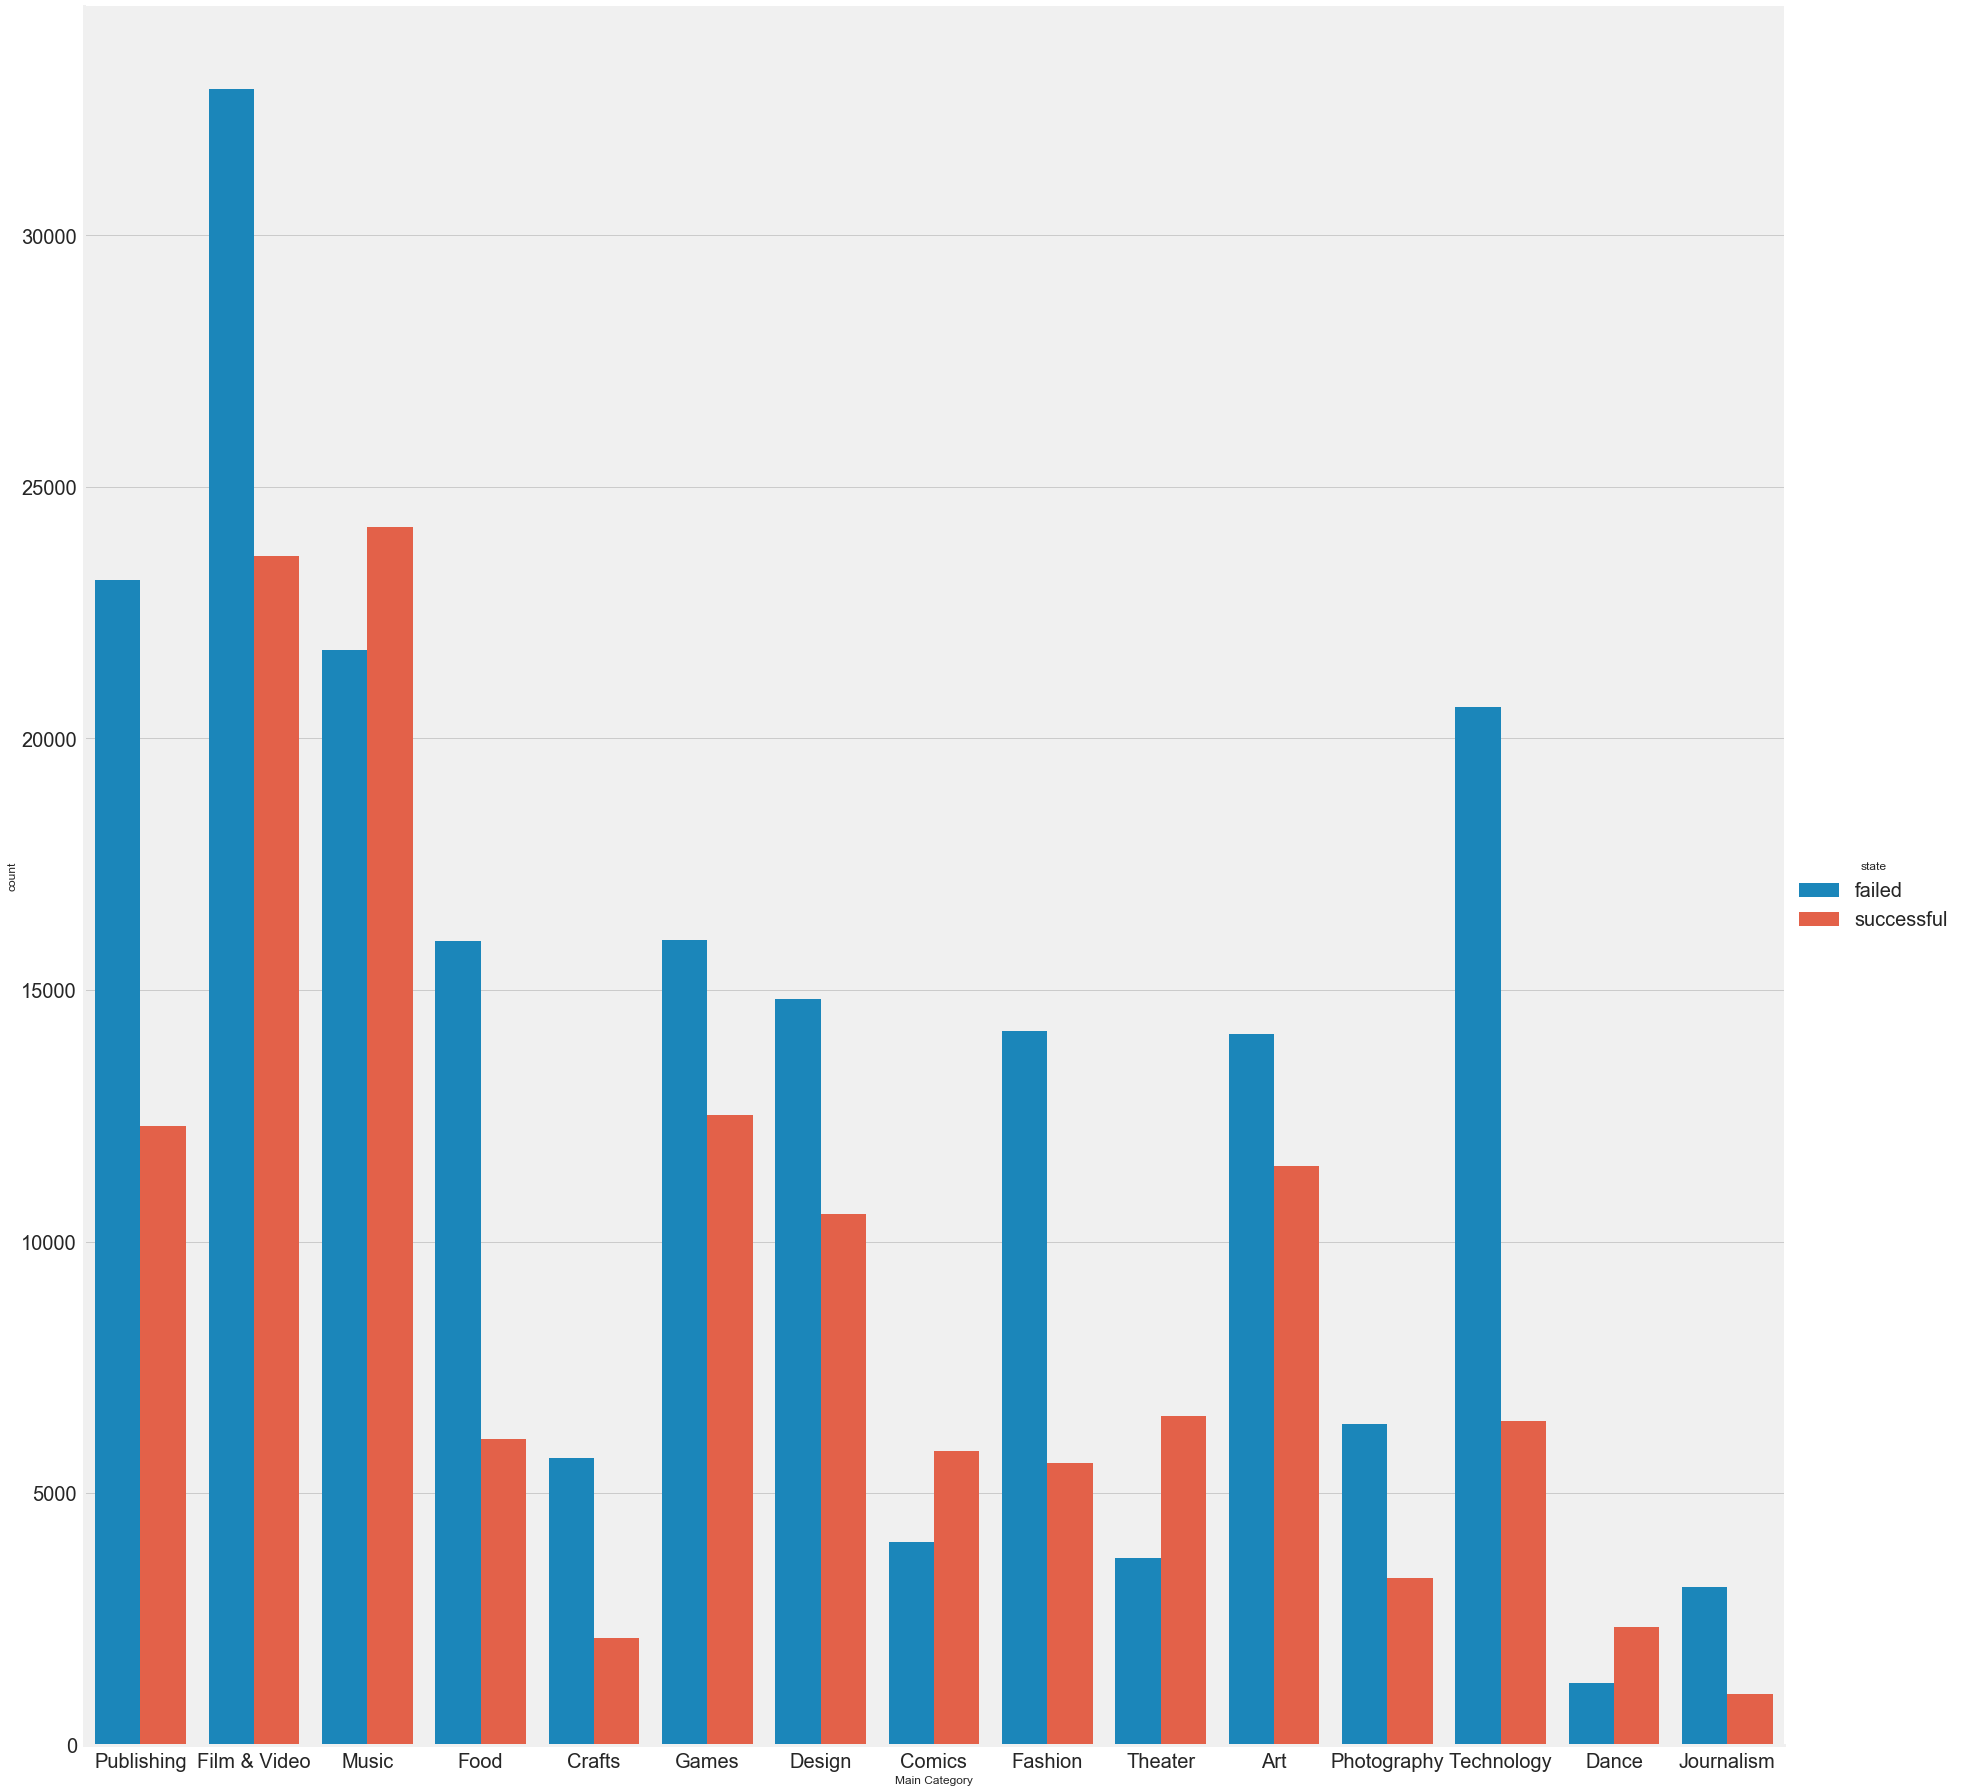

In [19]:
viz = data[(data['state'] == 'successful') | (data['state'] == 'failed')]
sns.factorplot('main_category',data=viz,kind='count',hue='state',size=25)
plt.xlabel('Main Category')

## Feature Engineering

### New Features to Create

* Project Name Length - **Done** 
* Number of Capital Letters in Project Name - **Done**
* Project Length: Number of days between Launch Date and Deadline - **Done**

In [20]:
# Create project name length feature
data['name_length'] = data.name.str.len()

# Create capital letters feature
data['caps_in_name'] = data.name.str.count('[A-Z]')

# Create campaign length feature (in days)
data.launched = pd.to_datetime(data.launched)
data.deadline = pd.to_datetime(data.deadline)
data['cam_length'] = data.deadline.subtract(data.launched).astype('timedelta64[D]')

data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,name_length,caps_in_name,cam_length
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95,31.00,4.00,58.00
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00,45.00,12.00,59.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00,14.00,2.00,44.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00,49.00,7.00,29.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00,58.00,7.00,55.00


Text(0.5,0,'Project Name Length')

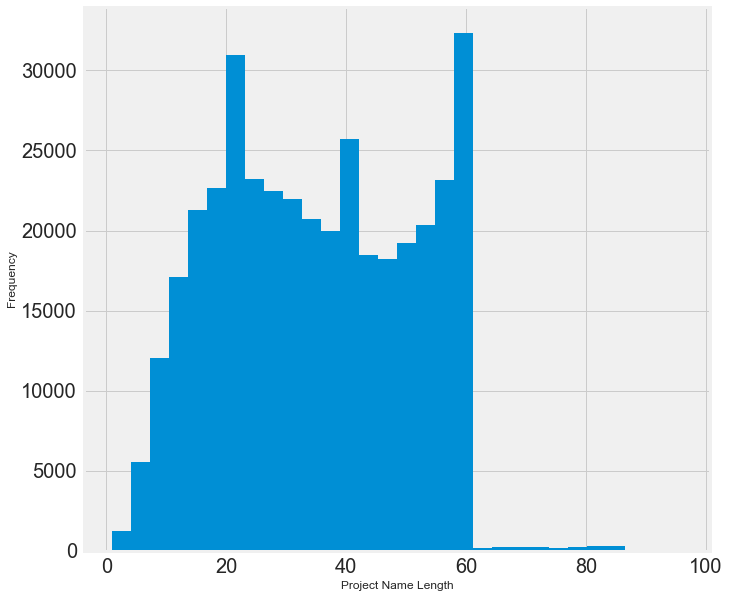

In [21]:
# Plot a new feature: Project Name Length
data.name_length.plot(kind='hist',figsize=(10,10),bins=30)
plt.xlabel('Project Name Length')

## Data Preparation

### To-do
* Remove columns *usd_pledged_real*, *goal*, *category*, *'usd pledged'* and *ID* - **Done**
* Remove columns 'name', 'deadline', 'launched' - **Done**
* Remove rows with state 'live' - **Done**
* Revise rows with state 'undefined' based on the goal and pledges:
    * If pledges >= goal, encode 1; otherwise encode 0. - **Done**
* Encode state 'successful' as 1; encode 'failed', 'canceled' and 'suspended' as 0 - **Done**
* One-hot encode *country*, *main_category* and *currency* - **Done**
* Split off target feature (state) from input features - **Done**
* Split dataset into train and test sets - **Done**

In [22]:
# Drop projects with NaNs in name
data = data.drop(data[data.name.isnull()].index,0)

# Remove 'name', 'deadline' and 'launched' features
data = data.drop('name',1)
data = data.drop('deadline',1)
data = data.drop('launched',1)

# Re-assign projects with state 'undefined'
maskon = (data.state == 'undefined') & (data.pledged >= data.goal)
column_name = 'state'
data.loc[maskon,column_name] = 'successful'

maskoff = (data.state == 'undefined') & (data.pledged < data.goal)
data.loc[maskoff,column_name] = 'failed'

# Only use projects that are successful or failed
data = data[data.state != 'live']
data = data[data.state != 'canceled']
data = data[data.state != 'suspended']

# Drop 'pledged' and 'goal' variables
data = data.drop('pledged',1)
data = data.drop('goal',1)

# Drop rows with weird values
data = data.drop(data[(data['usd pledged'].isnull()) & (data.country == 'N,0"')].index,0)

# Drop unnecessary columns
data = data.drop('ID',1)
data = data.drop('usd pledged',1)
data = data.drop('usd_pledged_real',1)

# Encode successful as 1;'failed', 'canceled' and 'suspended' as 0
success = data.state == 'successful'
#unsuccess = (data.state == 'failed') | (data.state == 'canceled') | (data.state == 'suspended')
failed = (data.state == 'failed')
data.loc[success,column_name] = 1
data.loc[failed,column_name] = 0

# One-hot encode country, main_category and currency
data = pd.get_dummies(data, columns=['country','category','main_category','currency'])

In [23]:
print("After pre-processing, the dataset has {} observations on {} features.".format(data.shape[0],data.shape[1]))

After pre-processing, the dataset has 331462 observations on 216 features.


In [24]:
# Split input and target features
y = data['state']
X = data.drop('state',1)

# Train-test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Test set has {} samples.".format(X_test.shape[0]))

Training set has 265169 samples.
Test set has 66293 samples.


In [25]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 265169 entries, 41940 to 139260
Columns: 215 entries, backers to currency_USD
dtypes: float64(4), int64(1), uint8(210)
memory usage: 65.2 MB


# Part 3: Model Building and Selection

## To-do

* All-numerical dataset for working with the models - **Done**
* Decision Tree (base estimator for AdaBoost) - **Done**
* Logistic Regression Benchmark Model - **Done**
* SVM Classifier - **Done**
* AdaBoost Classifier - **Done**
* XGBoost Classifier - **Done**
* Grid Search - **Done**

In [26]:
# Initialise the three classifiers
#dtc = DecisionTreeClassifier(random_state=42)
clf_bench = LogisticRegression(random_state=42)
clf1 = LinearSVC(max_iter=1500,random_state=42)
#clf1 = SVC(kernel='linear',random_state=42)
clf2 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),learning_rate=0.8,random_state=42)
clf3 = xgb.XGBClassifier(learning_rate=0.8,random_state=42,verbose=True)

In [27]:
# Logistic Regression
t0=time.clock()
clf_bench.fit(X_train,y_train)
logit_traintime=round(time.clock()-t0,3)
logit_pred = clf_bench.predict(X_test)
logit_acc = round(accuracy_score(y_test,logit_pred) * 100,2)
logit_f1 = round(f1_score(y_test,logit_pred),6)

print("Logistic Regression model accuracy: {}%\nLogistic Regression F1 score: {}".format(logit_acc,logit_f1))
print("Logistic Regression training time: {}s".format(logit_traintime))

Logistic Regression model accuracy: 90.68%
Logistic Regression F1 score: 0.878863
Logistic Regression training time: 2.204s


In [28]:
# SVM Training and Output
t0 = time.clock()
clf1.fit(X_train,y_train)
SVM_traintime=round(time.clock()-t0,3)
SVM_pred = clf1.predict(X_test)
SVM_acc = round(accuracy_score(y_test,SVM_pred) * 100, 2)
SVM_f1 = round(f1_score(y_test,SVM_pred), 6)

print("SVM model accuracy: {}%\nSVM F1 score: {}".format(SVM_acc,SVM_f1))
print("SVM training time: {}s".format(SVM_traintime))

SVM model accuracy: 92.42%
SVM F1 score: 0.905844
SVM training time: 75.846s


In [29]:
# AdaBoost Training and Output
t0=time.clock()
clf2.fit(X_train,y_train)
ada_traintime=round(time.clock()-t0,3)
ada_pred = clf2.predict(X_test)
ada_acc = round(accuracy_score(y_test,ada_pred) * 100,2)
ada_f1 = round(f1_score(y_test,ada_pred), 6)

print("AdaBoost model accuracy: {}%\nAdaBoost F1 score: {}".format(ada_acc,ada_f1))
print("AdaBoost training time: {}s".format(ada_traintime))

AdaBoost model accuracy: 92.97%
AdaBoost F1 score: 0.914735
AdaBoost training time: 20.532s


In [30]:
# XGBoost Training and Output
t0 = time.clock()
clf3.fit(X_train,y_train)
xg_traintime=round(time.clock()-t0,3)
xg_pred = clf3.predict(X_test)
xg_acc = round(accuracy_score(y_test,xg_pred)*100, 2)
xg_f1 = round(f1_score(y_test,xg_pred), 6)

print("XGBoost model accuracy: {}%\nXGBoost F1 score: {}".format(xg_acc,xg_f1))
print("XGBoost training time: {}s".format(xg_traintime))

XGBoost model accuracy: 93.47%
XGBoost F1 score: 0.919792
XGBoost training time: 173.701s


In [31]:
model_scores = pd.DataFrame({'Model': ['Logistic Regression',
                                      'Linear SVM', 'AdaBoost Classifier','XGBoost Classifier' ],
                            'Accuracy': [logit_acc,SVM_acc,ada_acc,xg_acc],
                            'F1 Score': [logit_f1,SVM_f1,ada_f1,xg_f1],
                            'Training Time': [logit_traintime,SVM_traintime,ada_traintime,xg_traintime]})

model_scores = model_scores[['Model','Accuracy','F1 Score','Training Time']]

model_scores.sort_values(by='F1 Score',ascending=False)

,Model,Accuracy,F1 Score,Training Time
3,XGBoost Classifier,93.47,0.92,173.70
2,AdaBoost Classifier,92.97,0.91,20.53
1,Linear SVM,92.42,0.91,75.85
0,Logistic Regression,90.68,0.88,2.20


# Model Tuning

XGBoost turned out to be the best model, performance-wise. AdaBoost was very close, and took a much shorter time to train. Because they were so close in performance, I decided to tune both models using Grid Search and compare the optimised models in performance. However, XGBoost Grid Search failed to work on my local machine.



In [33]:
# Tuning the AdaBoost model using Grid Search cross validation
parameters = {'base_estimator__max_depth' : [2,3], 'n_estimators': [150,175]}
scorer = make_scorer(f1_score)
grid = GridSearchCV(clf2,parameters,scoring=scorer)

# Fitting the Grid Search object
ada_grid = grid.fit(X_train,y_train)

# Get the best AdaBoost estimator
ada_best=ada_grid.best_estimator_

# Predictions and scores of the optimised model
ada_best_pred = ada_best.predict(X_test)

ada_best_acc = round(accuracy_score(y_test,ada_best_pred) * 100,2)
ada_best_f1 = round(f1_score(y_test,ada_best_pred), 6)

print("Unoptimised AdaBoost model accuracy: {}%\nUnoptimised AdaBoost F1 score: {}".format(ada_acc,ada_f1))
print("Optimised AdaBoost model accuracy: {}%\nOptimised AdaBoost F1 score: {}".format(ada_best_acc,ada_best_f1))


Unoptimised AdaBoost model accuracy: 92.97%
Unoptimised AdaBoost F1 score: 0.914735
Optimised AdaBoost model accuracy: 93.48%
Optimised AdaBoost F1 score: 0.920039


In [34]:
ada_grid.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.8, n_estimators=150, random_state=42)

In [35]:
# Tuning the XGBoost model using Grid Search cross validation
parameters = {'max_depth' : [2,6]}
scorer = make_scorer(f1_score)
grid = GridSearchCV(clf3,parameters,scoring=scorer)

# Fitting the Grid Search object
xg_grid = grid.fit(X_train,y_train)

# Get the best AdaBoost estimator
xg_best=xg_grid.best_estimator_

# Predictions and scores of the optimised model
xg_best_pred = xg_best.predict(X_test)

xg_best_acc = round(accuracy_score(y_test,xg_best_pred) * 100,2)
xg_best_f1 = round(f1_score(y_test,xg_best_pred), 6)

print("Unoptimised XGBoost model accuracy: {}%\nUnoptimised XGBoost F1 score: {}".format(xg_acc,xg_f1))
print("Optimised XGBoost model accuracy: {}%\nOptimised XGBoost F1 score: {}".format(xg_best_acc,xg_best_f1))

Unoptimised XGBoost model accuracy: 93.47%
Unoptimised XGBoost F1 score: 0.919792
Optimised XGBoost model accuracy: 93.41%
Optimised XGBoost F1 score: 0.919241


In [36]:
xg_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.8, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, verbose=True)

In [37]:
# Train Optimised AdaBoost model to evaluate training time
t0 = time.clock()
ada_best=ada_best.fit(X_train,y_train)
ada_best_traintime=round(time.clock()-t0,3)
ada_best_pred =ada_best.predict(X_test)
ada_best_acc = round(accuracy_score(y_test,ada_best_pred)*100, 2)
ada_best_f1 = round(f1_score(y_test,ada_best_pred), 6)

In [38]:
# Train Optimised XGBoost model to evaluate training time
t0 = time.clock()
xg_best=xg_best.fit(X_train,y_train)
xg_best_traintime=round(time.clock()-t0,3)
xg_best_pred =xg_best.predict(X_test)
xg_best_acc = round(accuracy_score(y_test,xg_best_pred)*100, 2)
xg_best_f1 = round(f1_score(y_test,xg_best_pred), 6)

In [42]:
model_scores.loc[4]=['Optimised AdaBoost',ada_best_acc,ada_best_f1,ada_best_traintime]
model_scores.loc[5]=['Optimised XGBoost',xg_best_acc,xg_best_f1,xg_best_traintime]
model_scores.sort_values(by='F1 Score',ascending=False)

,Model,Accuracy,F1 Score,Training Time
4,Optimised AdaBoost,93.48,0.92,108.68
3,XGBoost Classifier,93.47,0.92,173.70
5,Optimised XGBoost,93.41,0.92,120.08
2,AdaBoost Classifier,92.97,0.91,20.53
1,Linear SVM,92.42,0.91,75.85
0,Logistic Regression,90.68,0.88,2.20


## Feature Importances

Plotting the most important 10 features for the optimised AdaBoost model threw up some interesting results. Some machine learning models, especially those based on decision trees - including AdaBoost and XGBoost - are able to report on feature importances, the relative importance of each feature with respect to the predictability of the target variable.

First, the number of backers of a project had the biggest contribution to explaining success or failure of the project, with a score of **0.34**. The project goal was the second most important feature, with a feature importance score of **0.26**.

Text(0,0.5,'Importance')

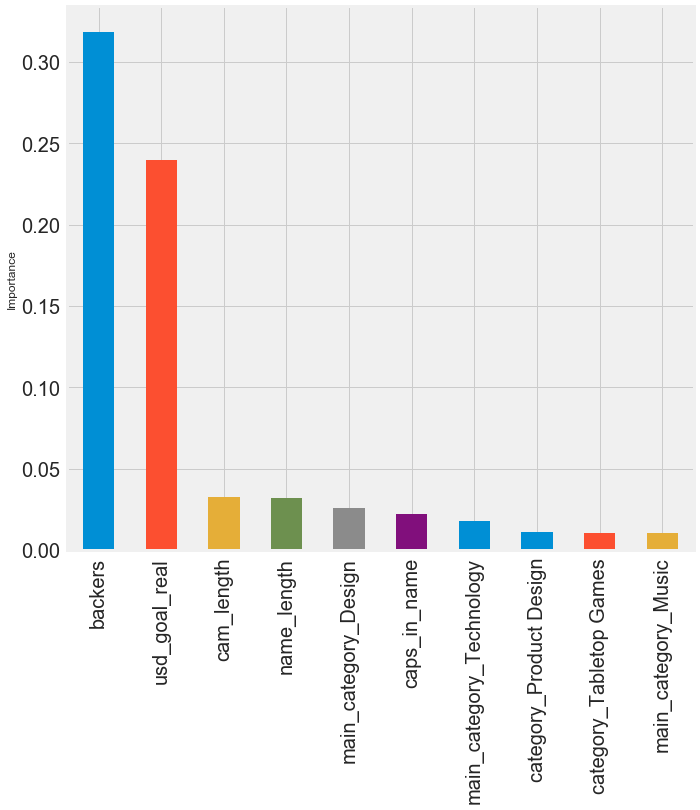

In [43]:
importances = pd.Series(ada_best.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='bar',figsize=(10,10))
plt.ylabel('Importance')

In [44]:
importances.nlargest(20).sort_values(ascending=False)

backers                    0.32
usd_goal_real              0.24
cam_length                 0.03
name_length                0.03
main_category_Design       0.03
caps_in_name               0.02
main_category_Technology   0.02
category_Product Design    0.01
category_Tabletop Games    0.01
main_category_Music        0.01
main_category_Publishing   0.01
main_category_Comics       0.01
category_Video Games       0.01
category_Accessories       0.01
category_Software          0.01
main_category_Games        0.01
currency_USD               0.01
main_category_Theater      0.01
category_3D Printing       0.01
category_Playing Cards     0.01
dtype: float64